In [ ]:
# default_exp learner

# Text as Image Learner

> How to customize learner object for our Match Pyramid Model?

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
import torchtext

from inspect import signature
from fastai.text.all import *
from sklearn.feature_extraction.text import CountVectorizer


In [ ]:
class ImageTextCallback(Callback):
    def __init__(self, model):
        self.labels = tuple()
        self.model_args = {k:v.default for k, v in signature(model.forward).parameters.items()}
    
    def before_batch(self):
        if 'labels' in self.xb[0].keys():
            self.labels = (self.xb[0]['labels'], )
        # make a tuple containing an element for each argument model excepts
        # if argument is not in xb it is set to default value
        self.learn.xb = tuple([self.xb[0]['pa'], self.xb[0]['pb']])
    
    def after_pred(self):
        if len(self.labels):
            loss = self.learn.loss_func(self.pred, self.labels[0]).clone()

            self.learn.loss_grad = loss 
            self.learn.loss      = loss.clone()
        
        self.learn.pred = self.pred
    
    def after_loss(self):
        if len(self.labels):
            self.learn.yb = self.labels[0]
            self.labels   = tuple()

In [ ]:
@delegates(Learner.__init__)
class ImageTextLearner(Learner):
    "Learner for training transformers from HuggingFace"
    def __init__(self, dls, model, **kwargs):
        super().__init__(dls, model, **kwargs)
        self.add_cb(ImageTextCallback(model))

In [ ]:
model = Model(my_vocab, max_len=72)
learn = ImageTextLearner(dls, model, loss_func=BCEWithLogitsLossFlat())

SuggestedLRs(valley=0.0010000000474974513)

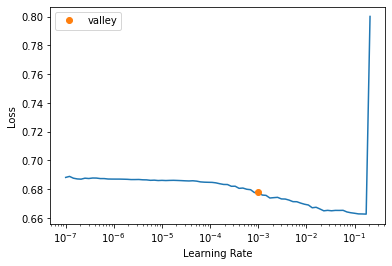

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,time
0,0.493515,0.488475,03:10
1,0.418052,0.427225,03:09
2,0.396194,0.406214,03:09
3,0.376598,0.401875,03:09
4,0.347590,0.400956,03:09


## Predictions

In [ ]:
%%time
test = pd.read_csv(RAW_DATA_PATH / 'test.csv')

# fill empty questions with ''
test.loc[:, 'question1'] = test.question1.fillna('')
test.loc[:, 'question2'] = test.question2.fillna('')

CPU times: user 5.14 s, sys: 604 ms, total: 5.74 s
Wall time: 5.92 s


In [ ]:
%%time
test_tok, _ = tokenize_df(test,     text_cols='question1', tok_text_col='q1')
test_tok, _ = tokenize_df(test_tok, text_cols='question2', tok_text_col='q2')

CPU times: user 2min 49s, sys: 34 s, total: 3min 23s
Wall time: 8min 47s


In [ ]:
tst_dl = dls.test_dl(test_items=test_tok)

In [ ]:
%%time
preds, _ = learn.get_preds(dl=tst_dl)

CPU times: user 1min 23s, sys: 11.9 s, total: 1min 35s
Wall time: 4min 40s


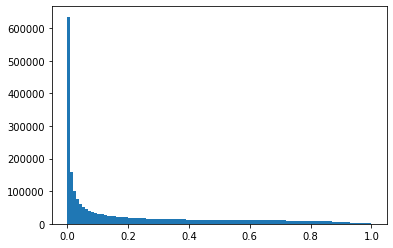

In [ ]:
plt.hist(np.array(preds.squeeze(dim=1).cpu()), bins=100);

In [ ]:
sub = pd.read_csv(RAW_DATA_PATH / 'sample_submission.csv')
sub.loc[:, 'is_duplicate'] = np.array(preds.squeeze(dim=1).cpu())

In [ ]:
sub.to_csv(RAW_DATA_PATH / 'submissions/image_text_word_vectorizer_0.3642.csv', index=False)